In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
warnings.filterwarnings('ignore')
%matplotlib inline

# 경향성이 있는 그래프의 선형적으로 증가할 수 있게 하는 함수 
def trend(time, slope = 0):
    return time * slope

# x: 시간축인 함수 plot 함수
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# 120개씩 자르는 함수 
def univariate_data(dataset, start_index, end_index):
    data = []
    history_size = 120
    start_index = start_index + history_size


    for i in range(start_index, end_index, 120): # 0
        indices = range(i - history_size, i) # [0 - 120] , [120 - 240] ...
        # Reshape data from (history_size,) to (history_size, 1)

        data.append(dataset[indices])

    return np.array(data)

for i in range(1,9):
    globals()['df_'+str(i) ]= pd.read_csv('./temperature_csv_file/temp_df_{}.csv'.format(i), encoding = 'cp949')

df_all = pd.concat([df_1, df_2], axis = 0)
df_all = pd.concat([df_all, df_3], axis = 0)
df_all = pd.concat([df_all, df_4], axis = 0)
df_all = pd.concat([df_all, df_5], axis = 0)
df_all = pd.concat([df_all, df_6], axis = 0)
df_all = pd.concat([df_all, df_7], axis = 0)
df_all = pd.concat([df_all, df_8], axis = 0)

df_all = df_all[:601800].reset_index().drop(columns = ['index'], axis = 0)

for i in range(1,8):
    globals()['df_'+str(i)+'_tmp'] = df_all[85920*(i-1):85920*i].reset_index().drop(columns=['index'], axis=0)


for i in range(1,8):
    mean = globals()['df_'+str(i)+'_tmp']['TEMP'].mean()
    diff  = 261.7292228119181 - mean
    globals()['df_'+str(i)+'_tmp']['TEMP'] += diff

for i in range(8,12):
    globals()['df_'+str(i)+'_tmp'] = globals()['df_'+str(i-5)+'_tmp'].copy()

N = 6
dx = (600 - df_1_tmp['TEMP'].mean()) / N # 전체 데이터에 대한 증가율 : 56.3785
dx_minute = dx / (len(df_1_tmp)-1) # 분당 증가율

time = np.arange(85920)
slope = dx_minute * 2

def trend(time, slope = 0):
    return time * slope

for i in range(2,12):
    series = np.round(trend(time, slope = slope) + globals()['df_'+str(i)+'_tmp']['TEMP'] + dx*(i-2), 3)
    globals()['df_'+str(i)+'_tmp']['TEMP'] = series


univariate_past_history = 120

for i in range(1,12):
    data = {'MEAN_TEMP' : [], 'STD' : [], 'MIN' : [], 'MAX' : [], 'SKEW' : [], 'KURT' : [], 'MEDIAN':[], '25%' : [], '75%' : [], 'Group' : [], 'batch_num' : []}

    for j in range(716):
        MEAN = np.round(globals()['df_'+str(i)+'_tmp']['TEMP'][120*j:120*(j+1)].mean(),3)
        MIN = np.min(globals()['df_'+str(i)+'_tmp']['TEMP'][120*j:120*(j+1)])
        MAX = np.max(globals()['df_'+str(i)+'_tmp']['TEMP'][120*j:120*(j+1)])
        STD = np.std(globals()['df_'+str(i)+'_tmp']['TEMP'][120*j:120*(j+1)])
        skew = globals()['df_'+str(i)+'_tmp']['TEMP'][120*j:120*(j+1)].skew()
        kurt = globals()['df_'+str(i)+'_tmp']['TEMP'][120*j:120*(j+1)].kurt()
        median = globals()['df_'+str(i)+'_tmp']['TEMP'][120*j:120*(j+1)].median()
        data[0], data[1] = np.percentile(globals()['df_'+str(i)+'_tmp']['TEMP'][120*j:120*(j+1)], q=[25,75])
        data['Group'].append(i)
        data['batch_num'].append(j+1)
        data['MEAN_TEMP'].append(MEAN)
        data['MIN'].append(MIN)
        data['MAX'].append(MAX)
        data['STD'].append(STD)
        data['SKEW'].append(skew)
        data['KURT'].append(kurt)
        data['MEDIAN'].append(np.round(median,3))
        data['25%'].append(np.round(data[0],3))
        data['75%'].append(np.round(data[1],3))

    globals()['group_'+str(i)] = pd.DataFrame(data)

TIME = pd.DataFrame({'TIME' : np.arange(7876)})
tmp = pd.concat([group_1, group_2], axis = 0)
tmp = pd.concat([tmp, group_3], axis = 0)
tmp = pd.concat([tmp, group_4], axis = 0)
tmp = pd.concat([tmp, group_5], axis = 0)
tmp = pd.concat([tmp, group_6], axis = 0)
tmp = pd.concat([tmp, group_7], axis = 0)
tmp = pd.concat([tmp, group_8], axis = 0)
tmp = pd.concat([tmp, group_9], axis = 0)
tmp = pd.concat([tmp, group_10], axis = 0)
tmp = pd.concat([tmp, group_11], axis = 0)
tmp = tmp.reset_index()
tmp = pd.concat([tmp, TIME], axis = 1)
tmp.drop(columns = ['index',0,1], inplace = True)
df = tmp

for i in range(1,12):
    globals()['df_temp_'+str(i)] = univariate_data(globals()['df_'+str(i)+'_tmp']['TEMP'], 0, len(df_1_tmp)+1)

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
X = df.iloc[:, :9].values
X_mean = df['MEAN_TEMP'].values
y = df['Group'].values - 1
X_mean = X_mean.reshape(X_mean.shape[0], 1)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
X_mean_scale = scaler.fit_transform(X_mean)
e = LabelEncoder()
Y = e.fit_transform(y)
Y = tf.keras.utils.to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 96)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
df

(6300, 9) (1576, 9) (6300,) (1576,)


,MEAN_TEMP,STD,MIN,MAX,SKEW,KURT,MEDIAN,25%,75%,Group,batch_num,TIME
0,284.192,1.275722,281.401,287.082,0.295874,-0.637850,283.830,283.258,285.130,1,1,0
1,284.353,1.052731,281.236,286.949,-0.106596,0.698932,284.267,283.797,284.914,1,2,1
2,285.276,1.043551,282.941,287.552,-0.194906,-0.650376,285.382,284.480,286.067,1,3,2
3,285.589,0.970639,283.867,288.153,0.674937,-0.078318,285.392,284.831,286.155,1,4,3
4,285.146,1.074865,281.689,286.664,-1.387162,1.773495,285.408,284.652,285.868,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...
7871,931.874,2.127380,926.730,936.100,0.082092,-0.390703,931.289,930.506,933.720,11,712,7871
7872,933.001,0.585021,931.564,934.166,-0.247556,-0.619292,933.079,932.608,933.400,11,713,7872
7873,933.236,0.659152,931.690,934.549,-0.459517,-0.417622,933.340,932.907,933.744,11,714,7873
7874,933.649,0.771575,932.209,935.319,0.079975,-1.172105,933.754,932.942,934.268,11,715,7874


In [7]:
df_all = pd.concat([df_1, df_2], axis = 0)
df_all = pd.concat([df_all, df_3], axis = 0)
df_all = pd.concat([df_all, df_4], axis = 0)
df_all = pd.concat([df_all, df_5], axis = 0)
df_all = pd.concat([df_all, df_6], axis = 0)
df_all = pd.concat([df_all, df_7], axis = 0)
df_all = pd.concat([df_all, df_8], axis = 0)
df_all = df_all.reset_index().drop(columns = ['index', 'kst'], axis = 0)
df_all

,date,TEMP
0,20230101,286.797
1,20230101,287.082
2,20230101,285.938
3,20230101,285.772
4,20230101,286.357
...,...,...
601887,20230801,280.894
601888,20230801,280.625
601889,20230801,280.475
601890,20230801,280.545


In [35]:
601892 // 60, 601892 % 60

(10031, 32)

In [37]:
10031 * 60

601860

In [42]:

for i in range(1,8):
    globals()['df_'+str(i)+'_tmp'] = df_all[10031*(i-1):10031*i].reset_index().drop(columns=['index'], axis=0)

## Window size : 120, Stride : 60

In [45]:
for i in range(1,8):
    globals()['df_'+str(i)+'_tmp'] = df_all[85920*(i-1):85920*i].reset_index().drop(columns=['index'], axis=0)


for i in range(1,8):
    mean = globals()['df_'+str(i)+'_tmp']['TEMP'].mean()
    diff  = 261.7292228119181 - mean
    globals()['df_'+str(i)+'_tmp']['TEMP'] += diff

for i in range(8,12):
    globals()['df_'+str(i)+'_tmp'] = globals()['df_'+str(i-5)+'_tmp'].copy()

for i in range(2,12):
    series = np.round(trend(time, slope = slope) + globals()['df_'+str(i)+'_tmp']['TEMP'] + dx*(i-2), 3)
    globals()['df_'+str(i)+'_tmp']['TEMP'] = series

for i in range(1,12):
    data = {'MEAN_TEMP' : [], 'STD' : [], 'MIN' : [], 'MAX' : [], 'SKEW' : [], 'KURT' : [], 'MEDIAN':[], '25%' : [], '75%' : [], 'Group' : []}

    for j in range(0,85801,60):
        temp = globals()['df_'+str(i)+'_tmp']['TEMP'][j:j+120]
        MEAN = np.round(np.mean(temp), 3)
        MIN = np.min(temp)
        MAX = np.max(temp)
        STD = np.std(temp)
        skew = temp.skew()
        kurt = temp.kurt()
        data[0], data[1] = np.percentile(temp, q = [25,75])

        data['Group'].append(i)
        data['MEAN_TEMP'].append(MEAN)
        data['MIN'].append(MIN)
        data['MAX'].append(MAX)
        data['STD'].append(STD)
        data['SKEW'].append(skew)
        data['KURT'].append(kurt)
        data['MEDIAN'].append(np.round(median,3))
        data['25%'].append(np.round(data[0],3))
        data['75%'].append(np.round(data[1],3))

    globals()['group_'+str(i)] = pd.DataFrame(data)

TIME = pd.DataFrame({'TIME' : np.arange(15741)})
tmp = pd.concat([group_1, group_2], axis = 0)
tmp = pd.concat([tmp, group_3], axis = 0)
tmp = pd.concat([tmp, group_4], axis = 0)
tmp = pd.concat([tmp, group_5], axis = 0)
tmp = pd.concat([tmp, group_6], axis = 0)
tmp = pd.concat([tmp, group_7], axis = 0)
tmp = pd.concat([tmp, group_8], axis = 0)
tmp = pd.concat([tmp, group_9], axis = 0)
tmp = pd.concat([tmp, group_10], axis = 0)
tmp = pd.concat([tmp, group_11], axis = 0)
tmp = tmp.reset_index()
tmp = pd.concat([tmp, TIME], axis = 1)
tmp.drop(columns = ['index',0,1], inplace = True)
df = tmp

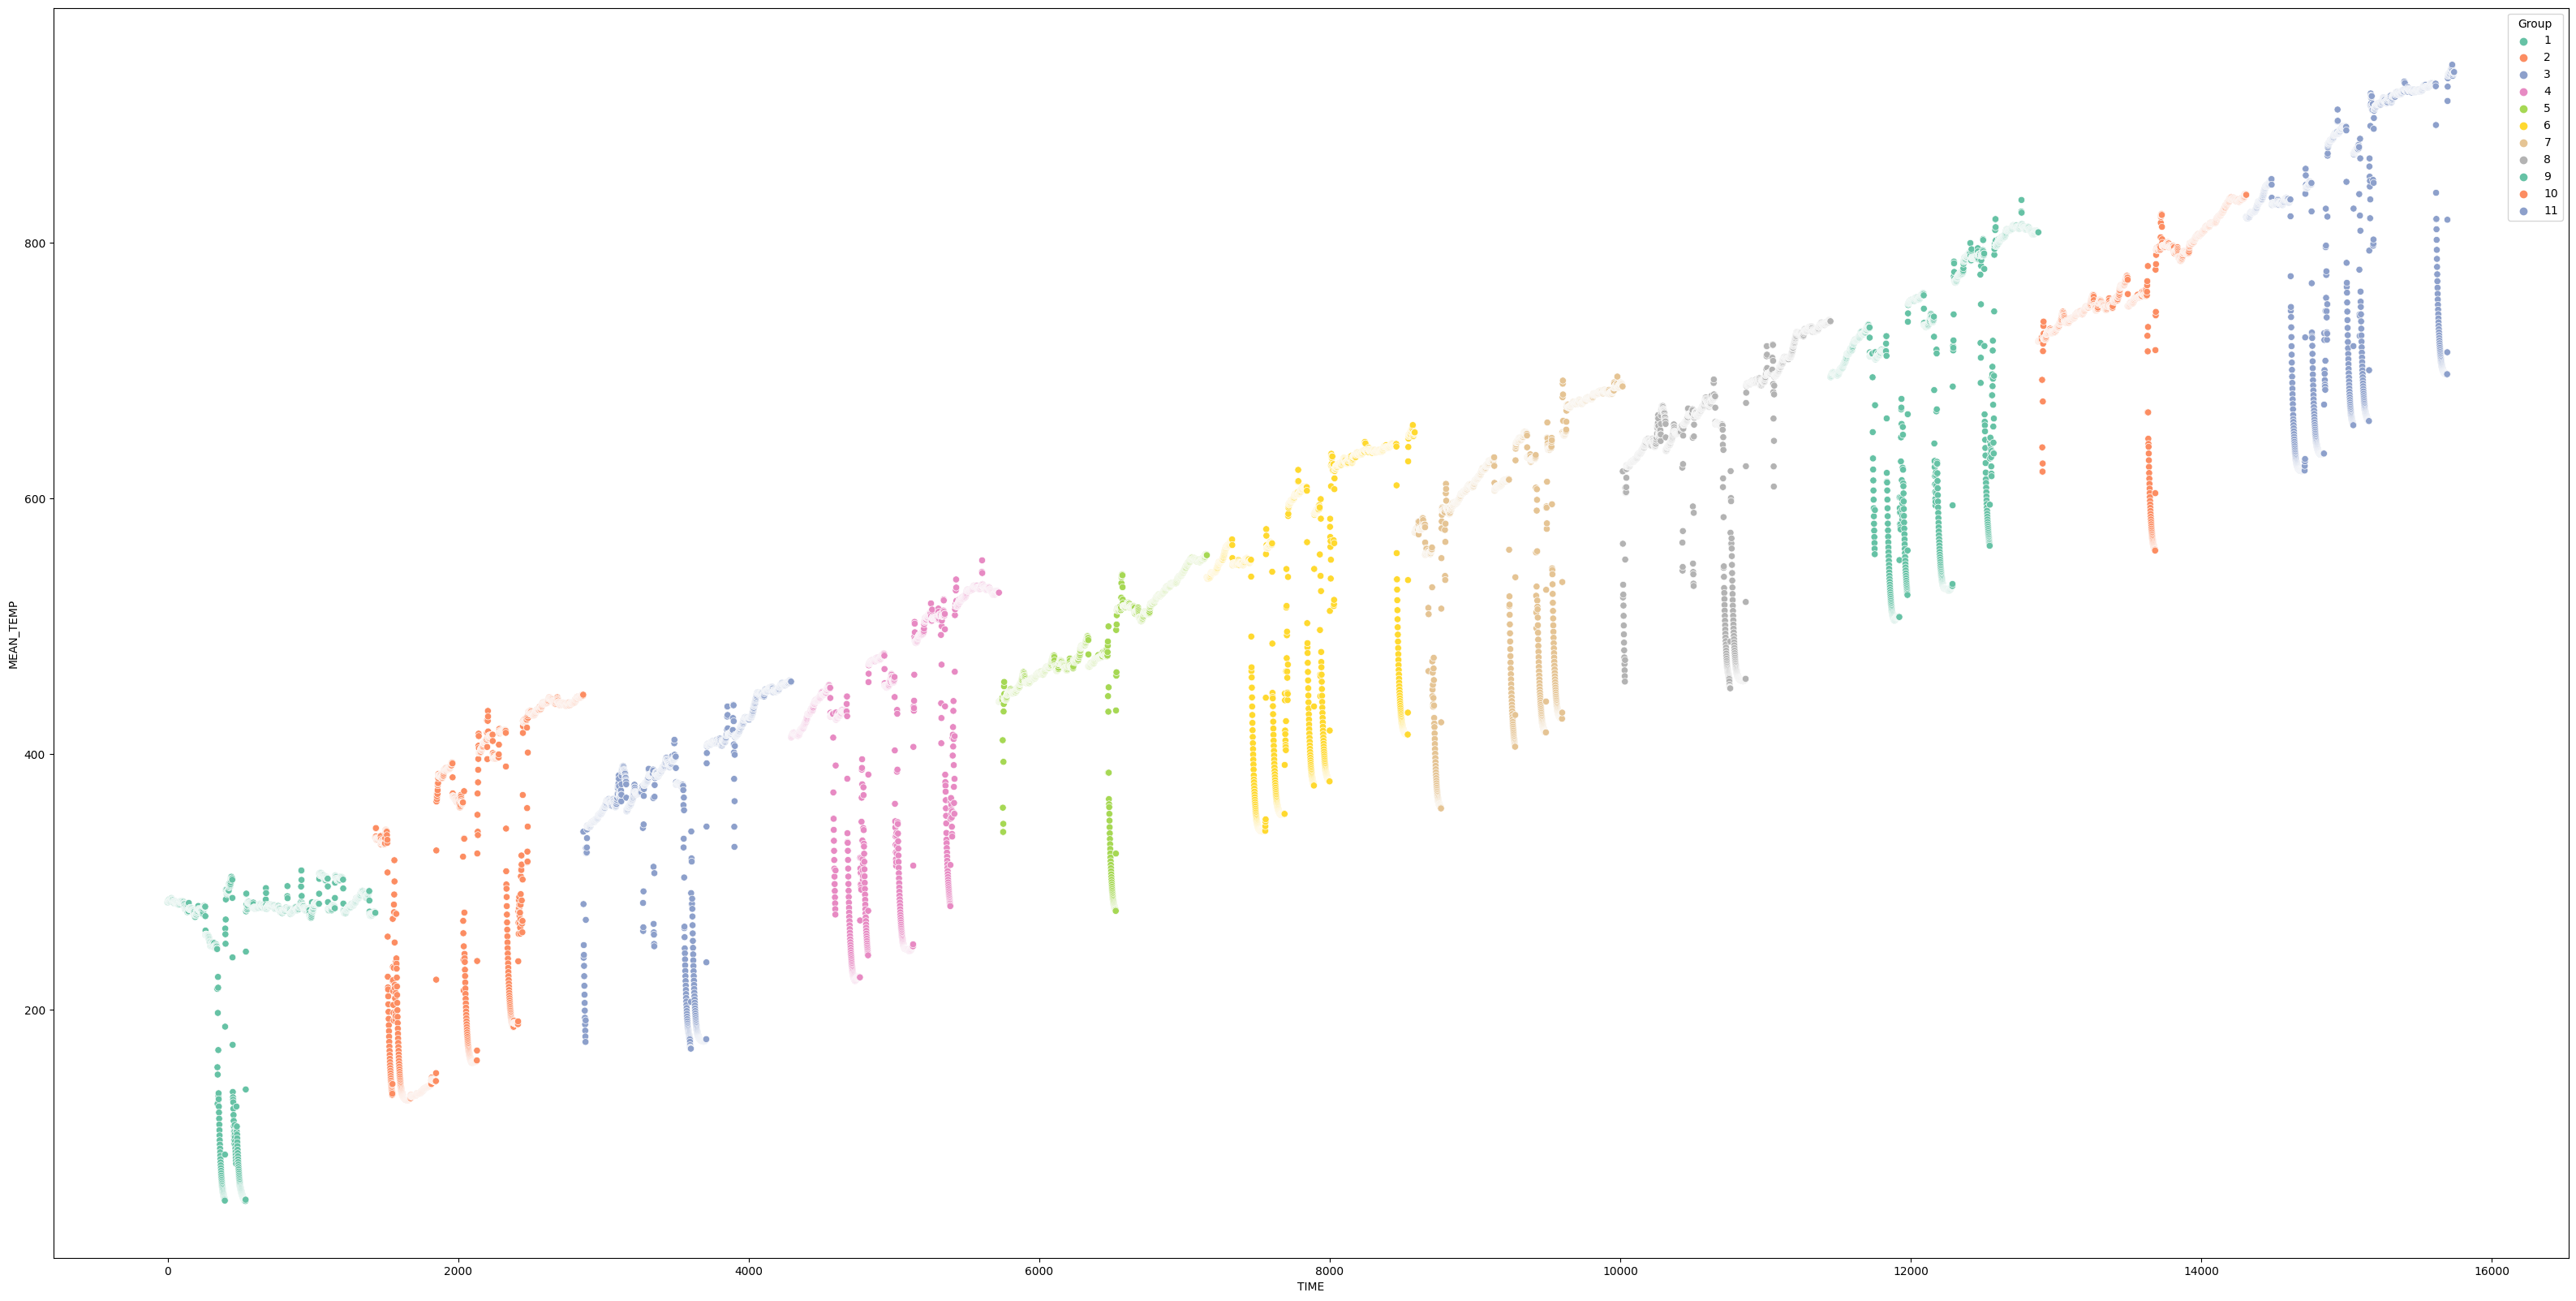

In [72]:
plt.figure(figsize = (40,20))
sns.scatterplot(data = df, x = 'TIME', y = 'MEAN_TEMP', hue = 'Group', palette='Set2')
plt.show()

In [73]:
df

,MEAN_TEMP,STD,MIN,MAX,SKEW,KURT,MEDIAN,25%,75%,Group,TIME
0,284.192,1.275722,281.401,287.082,0.295874,-0.637850,933.649,283.258,285.130,1,0
1,284.353,1.075364,282.258,286.949,0.285079,-0.405549,933.649,283.639,285.074,1,1
2,284.353,1.052731,281.236,286.949,-0.106596,0.698932,933.649,283.797,284.914,1,2
3,284.929,1.196956,281.236,287.552,-0.350329,0.298880,933.649,284.118,285.819,1,3
4,285.276,1.043551,282.941,287.552,-0.194906,-0.650376,933.649,284.480,286.067,1,4
...,...,...,...,...,...,...,...,...,...,...,...
15736,933.236,0.659152,931.690,934.549,-0.459517,-0.417622,933.649,932.907,933.744,11,15736
15737,933.374,0.542534,932.209,934.549,0.042072,-0.972253,933.649,932.924,933.818,11,15737
15738,933.649,0.771575,932.209,935.319,0.079975,-1.172105,933.649,932.942,934.268,11,15738
15739,934.024,0.554419,932.681,935.378,0.106393,-0.278596,933.649,933.663,934.451,11,15739


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:, :9].values
y = df['Group'].values


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 96)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12592, 9) (3149, 9) (12592,) (3149,)


In [90]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators = 200)

lgbm.fit(X_train, y_train,
         eval_metric = 'multi_logloss',
         eval_set = [(X_test, y_test)])
lgbm_predict = lgbm.predict(X_test)
print(accuracy_score(y_test, lgbm_predict))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 12592, number of used features: 8
[LightGBM] [Info] Start training from score -2.413502
[LightGBM] [Info] Start training from score -2.389828
[LightGBM] [Info] Start training from score -2.390694
[LightGBM] [Info] Start training from score -2.423311
[LightGBM] [Info] Start training from score -2.398531
[LightGBM] [Info] Start training from score -2.392431
[LightGBM] [Info] Start training from score -2.395912
[LightGBM] [Info] Start training from score -2.394170
[LightGBM] [Info] Start training from score -2.402911
[LightGBM] [Info] Start training from score -2.409959
[LightGBM] [Info] Start training from score -2.366700
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [81]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(accuracy_score(y_test, knn_pred))

0.7329310892346776


In [92]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 42)

dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)
print(accuracy_score(y_test, dtc_pred))

0.7770720863766275


In [91]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth = 50, random_state = 96)
clf.fit(X_train, y_train)

clf_predict = clf.predict(X_test)
print(accuracy_score(clf_predict, y_test))

0.8189901556049539


## 사람이 판단 하는 if 문

In [ ]:
def function(data):
    

## Window size : 60, Stride : 30

In [ ]:
for i in range(1,8):
    globals()['df_'+str(i)+'_tmp'] = df_all[85920*(i-1):85920*i].reset_index().drop(columns=['index'], axis=0)


for i in range(1,8):
    mean = globals()['df_'+str(i)+'_tmp']['TEMP'].mean()
    diff  = 261.7292228119181 - mean
    globals()['df_'+str(i)+'_tmp']['TEMP'] += diff

for i in range(8,12):
    globals()['df_'+str(i)+'_tmp'] = globals()['df_'+str(i-5)+'_tmp'].copy()

for i in range(2,12):
    series = np.round(trend(time, slope = slope) + globals()['df_'+str(i)+'_tmp']['TEMP'] + dx*(i-2), 3)
    globals()['df_'+str(i)+'_tmp']['TEMP'] = series

for i in range(1,12):
    data = {'MEAN_TEMP' : [], 'STD' : [], 'MIN' : [], 'MAX' : [], 'SKEW' : [], 'KURT' : [], 'MEDIAN':[], '25%' : [], '75%' : [], 'Group' : []}

    for j in range(0,85801,60):
        temp = globals()['df_'+str(i)+'_tmp']['TEMP'][j:j+120]
        MEAN = np.round(np.mean(temp), 3)
        MIN = np.min(temp)
        MAX = np.max(temp)
        STD = np.std(temp)
        skew = temp.skew()
        kurt = temp.kurt()
        data[0], data[1] = np.percentile(temp, q = [25,75])

        data['Group'].append(i)
        data['MEAN_TEMP'].append(MEAN)
        data['MIN'].append(MIN)
        data['MAX'].append(MAX)
        data['STD'].append(STD)
        data['SKEW'].append(skew)
        data['KURT'].append(kurt)
        data['MEDIAN'].append(np.round(median,3))
        data['25%'].append(np.round(data[0],3))
        data['75%'].append(np.round(data[1],3))

    globals()['group_'+str(i)] = pd.DataFrame(data)

TIME = pd.DataFrame({'TIME' : np.arange(15741)})
tmp = pd.concat([group_1, group_2], axis = 0)
tmp = pd.concat([tmp, group_3], axis = 0)
tmp = pd.concat([tmp, group_4], axis = 0)
tmp = pd.concat([tmp, group_5], axis = 0)
tmp = pd.concat([tmp, group_6], axis = 0)
tmp = pd.concat([tmp, group_7], axis = 0)
tmp = pd.concat([tmp, group_8], axis = 0)
tmp = pd.concat([tmp, group_9], axis = 0)
tmp = pd.concat([tmp, group_10], axis = 0)
tmp = pd.concat([tmp, group_11], axis = 0)
tmp = tmp.reset_index()
tmp = pd.concat([tmp, TIME], axis = 1)
tmp.drop(columns = ['index',0,1], inplace = True)
df = tmp